In [1]:
from scipy.io import loadmat
import os
from datetime import datetime
import numpy as np
from tensorflow.keras.preprocessing import image
from tqdm import tqdm_notebook
import h5py
import time


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calculate_age(taken, dob):
    """
    Calculate age of the image based on the date of birth and when the image is taken
    """
    birth = datetime.fromordinal(max(int(dob) - 366, 1))
    
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [3]:
def load_data(data_dir, dataset):
    """
    Loads infomration about the images and filters the images based on quality measures like multiple 
    people in the image and bougus ages etc.
    """
    
    # load from mat file
    meta = loadmat(os.path.join(data_dir, "{}.mat".format(dataset)))
    
    # extract information from the metadata-dict
    full_path = meta[dataset][0, 0]["full_path"][0]
    face_score = meta[dataset][0, 0]["face_score"][0]
    second_face_score = meta[dataset][0, 0]["second_face_score"][0]
    dob = meta[dataset][0, 0]["dob"][0]
    photo_taken = meta[dataset][0, 0]["photo_taken"][0]
    name = meta[dataset][0, 0]["name"][0]
    gender = meta[dataset][0, 0]['gender'][0]
    
    # Calculate ages
    ages = np.array([calculate_age(photo_taken[i], dob[i]) for i in range(len(dob))])
    
    # Loop over the images to find what images to delete
    indecies_to_delete = []
    for i, age in enumerate(ages):
        # if age is higher than 100 or less than 0, mark the image for removal
        if age > 100 or age < 0:
            indecies_to_delete.append(i)
        
        # If the face detection score is lower than 3, remove the image
        elif face_score[i] < 1.5:
            indecies_to_delete.append(i)
            
        # If we have more than 1 face in the image, remove the image
        elif not np.isnan(second_face_score[i]):
            indecies_to_delete.append(i)
        
        # If we do not have the gender information, remove the image
        elif np.isnan(gender[i]):
            indecies_to_delete.append(i)
            
        #if face_score[i] < 0:
            #print(full_path[i], face_score[i])
            
    print("Removing", len(indecies_to_delete), "images")
    
    # Remove the marked images
    ages = np.delete(ages, indecies_to_delete)
    full_path = np.delete(full_path, indecies_to_delete)
    
    gender = np.delete(gender, indecies_to_delete)
     
    images = []
    for img_path in tqdm_notebook(full_path):
        images.append(img_path[0])
    
    images = np.array(images)
    
    return images, ages, gender

In [4]:
def load_images(data_dir, image_paths, image_shape):
    """
    Loads the images from disk and reshape to a standard format of image_shape
    """
    images = []
    num_images = len(image_paths)
    
    for i, image_path in tqdm_notebook(enumerate(image_paths), total=num_images, leave=False):
    
        try:
            # Load image
            loaded_image = image.load_img(os.path.join(data_dir, image_path), target_size=image_shape)
            
            # Convert PIL image to numpy ndarray
            loaded_image = image.img_to_array(loaded_image).astype(np.uint8)
            #print(loaded_image)

            # Add another dimension (Add batch dimension)
            #loaded_image = np.expand_dims(loaded_image, axis=0).astype(np.uint8)
            #print(loaded_image)
            
            images.append(loaded_image)
            
        except Exception as e:
            print("Error:", i, e)
    images = np.array(images)

    return images

In [5]:
def image_chunk_generator(images, chunksize):
    """Create a simple generator that iterates over blocks of images"""
    for i in range(0, images.shape[0], chunksize):
        yield images[i:i + chunksize]

## Wiki

In [6]:
w_images, w_ages, w_gender = load_data("data/wiki_crop", "wiki")
image_shape = (64, 64, 3)

w_num_imgs = w_images.shape[0]
chunksize = w_num_imgs // 120

chunk_generator = image_chunk_generator(w_images, chunksize)

w_finnished_images = []

for image_chunk in tqdm_notebook(chunk_generator, total = 121, desc="Image chunks"):
    #loaded_images = load_images("data/imdb_crop", image_chunk, (image_shape[0], image_shape[1]))
    loaded_images = load_images("data/wiki_crop", image_chunk, (image_shape[0], image_shape[1]))
    w_finnished_images.append(loaded_images)

w_loaded_images = np.concatenate(w_finnished_images)

Removing 27098 images


59
1.0
(35230, 64, 64, 3)


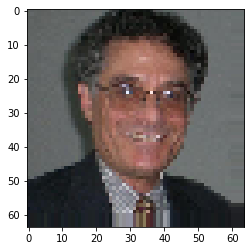

In [7]:
n=1
plt.imshow(w_loaded_images[n]);
print(w_ages[n])
print(w_gender[n])
print(w_loaded_images.shape)

## IMDB

In [8]:
i_images, i_ages, i_gender = load_data("data/imdb_crop", "imdb")
image_shape = (64, 64, 3)

i_num_imgs = i_images.shape[0]
chunksize = i_num_imgs // 400

chunk_generator = image_chunk_generator(i_images, chunksize)

i_finnished_images = []

for image_chunk in tqdm_notebook(chunk_generator, total = 401, desc="Image chunks"):
    loaded_images = load_images("data/imdb_crop", image_chunk, (image_shape[0], image_shape[1]))
    i_finnished_images.append(loaded_images)

i_loaded_images = np.concatenate(i_finnished_images)

Removing 307035 images


69
1.0
(153688, 64, 64, 3)


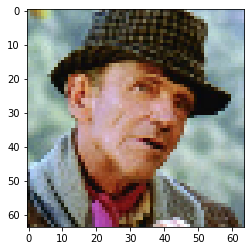

In [9]:
n=0
plt.imshow(i_loaded_images[n]);
print(i_ages[n])
print(i_gender[n])
print(i_loaded_images.shape)

In [10]:
images = np.concatenate([w_loaded_images, i_loaded_images])
ages = np.concatenate([w_ages, i_ages])
gender = np.concatenate([w_gender, i_gender])
print(images.shape)

(188918, 64, 64, 3)


In [11]:
with h5py.File("preprocesed_gender_age_test.hdf5", "w") as f:
    f.create_dataset("images", data=images, compression="gzip", compression_opts=4)
    f.create_dataset("ages", data=ages)
    f.create_dataset("gender", data=gender)